# Modelling Extreme values for the Wind Farm project

This notebook is a brief example of the possibilities offered by the toolbox for modeling extreme values, adapted from the tools provided from the ResourceCode website.

It relies on the `pyextreme` library which get installed with the Resourcecode toolbox. Here we demonstrate 2 examples of univariate modeling as shown in class. For more information, see https://georgebv.github.io/pyextremes/.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from pyextremes import (
    plot_mean_residual_life,
    plot_parameter_stability, 
    EVA
)
import resourcecode

from resourcecode.eva import (
    censgaussfit,
    get_fitted_models,
    get_gpd_parameters,
    run_simulation,
    huseby,
)
import warnings
warnings.filterwarnings("ignore")

We first load the data from the Bretagne Sud 1 location `126096` (coordinates: $(47.5882, -3.3215)$).

In [2]:
point_id, dist_m = resourcecode.data.get_closest_point(latitude=47.5882, longitude=-3.3215)
print(point_id, dist_m)

126096 238.69


In [3]:
client = resourcecode.Client()
data = client.get_dataframe_from_criteria(
    """
{
    "node": 126096,
    "start": 0,
    "end": 99999903600,
    "parameter": ["hs","uwnd","vwnd"]
}
"""
)

In [4]:
data.head()

,hs,uwnd,vwnd
1994-01-01 00:00:00,3.126,10.2,-6.2
1994-01-01 01:00:00,3.200,9.6,-5.9
1994-01-01 02:00:00,3.242,8.9,-4.8
1994-01-01 03:00:00,3.280,9.2,-4.1
1994-01-01 04:00:00,3.304,9.4,-4.1


From the $u$ and $v$ components of the wind, calculate the wind speed and direction.

In [5]:
data["wspd"], data["wdir"] = resourcecode.utils.zmcomp2metconv(data.uwnd, data.vwnd)

In [6]:
data.head()

,hs,uwnd,vwnd,wspd,wdir
1994-01-01 00:00:00,3.126,10.2,-6.2,11.936499,301.293039
1994-01-01 01:00:00,3.200,9.6,-5.9,11.268097,301.574191
1994-01-01 02:00:00,3.242,8.9,-4.8,10.111874,298.339132
1994-01-01 03:00:00,3.280,9.2,-4.1,10.072239,294.020247
1994-01-01 04:00:00,3.304,9.4,-4.1,10.255243,293.565396


### Modelling univariate time series: Block maxima + GEVD (Generalized Extreme Value Distribution)

We show as an example here a **BM** (block maxima) model fitted to the $H_s$ time series. In this approach, the maximum value is identified within a "block" or fixed period in time, and then a GEVP distribution is fit to the data to estimate the return values.  

The same plot can readily be obtained for the other sea-state parameters.

After loading the data, apply the block method approach with a block size of 1 year (365.2425 days), where each data block must be at least 90% full to take into account in the analysis.

In [7]:
model = EVA(data.hs)
model.get_extremes(method="BM", block_size="365.2425D", min_last_block=0.9)

In [8]:
model.extremes.head()

date-time
1994-02-03 19:00:00    6.164
1995-09-07 14:00:00    7.448
1996-02-07 16:00:00    6.550
1997-11-09 12:00:00    5.766
1998-01-04 19:00:00    6.416
Name: hs, dtype: float64

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='date-time', ylabel='hs'>)

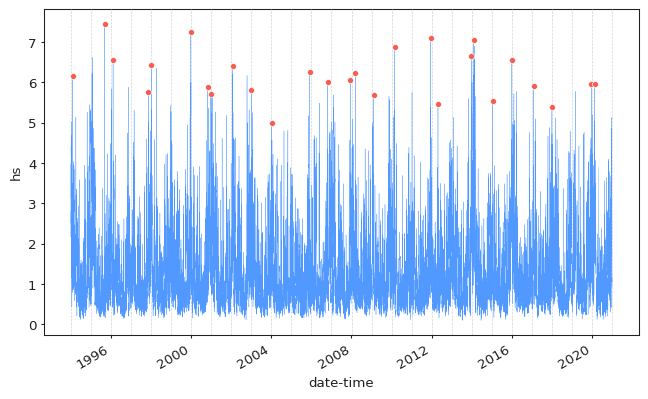

In [9]:
model.plot_extremes()

In [10]:
model.fit_model()

The parameter alpha specifies the confidence limits (default = 0.95).

In [11]:
model.plot_diagnostic(alpha=0.95)

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='hs'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='hs', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

The parameter n_samples indicates the number of bootstrap samples used to estimate the confidence bounds.

In [12]:
summary = model.get_summary(
        return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
        alpha=0.95,
        n_samples=1000,
    )
print(summary)

               return value  lower ci   upper ci
return period                                   
1.0                    -inf       NaN        NaN
2.0                6.091837  5.871934   6.324680
5.0                6.698079  6.369678   7.002260
10.0               7.099463  6.680628   7.481388
25.0               7.606614  7.048784   8.093064
50.0               7.982847  7.324889   8.542856
100.0              8.356302  7.598806   8.999799
250.0              8.848017  7.949229   9.602224
500.0              9.219300  8.200426  10.049424
1000.0             9.590315  8.445879  10.487585


### Modelling univariate time series: Peaks over threshold (POT) + GPD (Generalized Pareto Distribution)

We show as example here a **POT** (peaks over threshold) model fitted to the $H_s$ time series. This analysis first finds values over a specified threshold and then declusters these values using a predefined clustering distance, and finally finds the maximum value within each cluster. 

The same plot can readily be obtained for the other sea-state parameters.

We first can have a look at the quality of the fitted model, and to the corresponding return levels as a function of the selected wave height threshold. The parameters r and alpha specify the minimum time distance (duration) between adjacent clusters and the confidence limits (default = 0.95), respectively.

The shape and modified scale parameters define the Generalized Pareto Distribution, and they depend on the threshold value, but should be stable within a range of valid thresholds (e.g. less than ~3m here).

In [13]:
plot_parameter_stability(ts=data.hs,r='72H',alpha=.95);

The mean residual life plots the average excess value over a given threshold, and it should be approcimately linear above the threshold for which the GPD model is valid (e.g. <~3m)

In [14]:
plot_mean_residual_life(data.hs);

The analysis is completed for both Hs and the wind speed, specifying a window of 72 hours and a quantile of 0.98 for determining the threshold to specify.

In [15]:
quant=0.98
models = get_fitted_models(data[["hs","wspd"]],quantile=quant,r="72H")

In [16]:
models

[                           Univariate Extreme Value Analysis                            
                                       Source Data                                       
 ----------------------------------------------------------------------------------------
 Data label:                            hs      Size:                             236,688
 Start:                       January 1994      End:                        December 2020
                                      Extreme Values                                     
 ----------------------------------------------------------------------------------------
 Count:                                189      Extraction method:                    POT
 Type:                                high      Threshold:                          3.828
                                          Model                                          
 ----------------------------------------------------------------------------------------
 Model:   

In [17]:
models[0].plot_diagnostic(alpha=0.95);

In [18]:
models[1].plot_diagnostic(alpha=0.95);

In [19]:
pd.DataFrame(get_gpd_parameters(models),columns=["mu","sigma","xi"],index=["Hs","Wspd"])

,mu,sigma,xi
Hs,3.828000,1.325214,-0.305804
Wspd,13.730623,2.680247,-0.122354


In [20]:
summary_Hs = models[0].get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)
summary_Wspd = models[1].get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)
print(summary_Hs)
print(summary_Wspd)

               return value  lower ci  upper ci
return period                                  
1.0                5.771451  5.561006  5.984653
2.0                6.227978  5.996808  6.443483
5.0                6.700485  6.430962  6.922323
10.0               6.979559  6.668514  7.245419
25.0               7.268400  6.884234  7.623829
50.0               7.438997  7.002744  7.868518
100.0              7.577008  7.086239  8.084961
               return value   lower ci   upper ci
return period                                    
1.0               19.436488  18.771352  19.968451
2.0               20.753737  19.674029  21.471755
5.0               22.332120  20.561207  23.355530
10.0              23.413918  21.126560  24.747778
25.0              24.710173  21.687960  26.528439
50.0              25.598606  22.004144  27.836525
100.0             26.414799  22.263798  29.014650
